# Figures and analysis

This notebook contains scripts for producing the main figures and results accompanying the manuscript. Here we perform basic organization and processing of data, which is then passed to functions in figures.py (available at '/src' folder of this GitHub repository) for detailed formatting. The figures produced are stored as PDFs in the /figures folder.

## Contents

- [Overview and table of contents](#contents)
- [Loading libraries and global variables](#global)
- [Figures and data analysis](#figures)  
    - [Figure 1](#fig1)  
    - [Figure 2](#fig2)
    - [Figure 3](#fig3)
    - [Figure 4](#fig4)
    - [Figure 5](#fig5)
    - [Figure 6](#fig6)
    - [Figure 7](#fig7)
    - [Figure 8](#fig8)
    - [Supplementary Figure 1](#figs1)
    - [Supplementary Figure 2](#figs2)
    - [Supplementary Figure 3](#figs3)
    - [Supplementary Figure 4](#figs4)
    - [Supplementary Figure 5](#figs5)
    - [Supplementary Figure 6](#figs6)
    - [Supplementary Figure 7](#figs7)
    - [Supplementary Figure 8](#figs8)
    - [Supplementary Figure 9](#figs9)
    - [Supplementary Figure 10](#figs10)
    - [Supplementary Figure 11](#figs11)
    - [Supplementary Figure 12](#figs12)
    - [Supplementary Figure 13](#figs13)
    - [Supplementary Figure 14](#figs14)

<a id='global'></a>

## Libraries and variables

In [1]:
# Full library list and version numbers

print('This notebook was prepared using:')

import sys, os
from copy import deepcopy
import importlib
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy
import scipy.stats as stats
print('scipy version %s' % scipy.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import figures as FIG
sys.path.append('./src')
import simulation_setup as SS
import data_parser as DP
import estimate_covariance as EC

# GLOBAL VARIABLES

N = 1000        # number of sequences in the population
L = 50          # sequence length
T = 700         # number of generations
MU = 1e-3       # mutation rate
NUM_SELECTIONS = 10  # number of sets of selection coefficients that we used
NUM_TRIALS = 20  # for each set of selection coefficients, we simulated for 20 times
SAMPLE = [1000, 500, 100, 50, 10]  # sampling depth options when subsampling
RECORD = [1, 3, 5, 10]  # sampling time interval options when subsampling
LINEAR = [1, 5, 10, 20, 50, 100, 300]  # list of linear shrinkage strengths/sampling time intervals, e.g., interval=5, linear=5 ==> strength=25'
GAMMA = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]  # non-linear shrinkage parameter choices that we tested
TRUNCATE = [200, 300, 400, 500, 600, 700]  # truncate options to test performance using different lengths of data
WINDOW = [0, 1, 2, 3, 4, 5, 10, 20, 40, 80, 160]  # window choices that we tested

# loss functions for non-linear shrinkage that we tested
LOSS = ['Fro | $\hat{C}-C$', 'Fro | $\hat{C}^{-1}-C^{-1}$', 'Fro | $C^{-1}\hat{C}-I$',
        'Fro | $\hat{C}^{-1}C-I$', 'Fro | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$',
        'Nuc | $\hat{C}-C$', 'Nuc | $\hat{C}^{-1}-C^{-1}$', 'Nuc | $C^{-1}\hat{C}-I$',
        'Nuc | $\hat{C}^{-1}C-I$', 'Nuc | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$']

# GitHub directories
FIG_DIR = './figures'
DATA_DIR = './data'
SELECTION_DIR = './src/selection'
INITIAL_DIR = './src/initial'
SIMULATION_OUTPUT_DIR = './data/simulation_output'
SUBSAMPLE_OUTPUT_DIR = './data/subsample_output'
ESTIMATION_OUTPUT_DIR = './data/estimation_output'
JOB_DIR = './jobs'

# relative directories looking from shell scripts in JOB_DIR
SRC_DIR_REL = '../src'
DATA_DIR_REL = '../data'
SELECTION_DIR_REL = '../src/selection'
INITIAL_DIR_REL = '../src/initial'
SIMULATION_OUTPUT_DIR_REL = '../data/simulation_output'
SUBSAMPLE_OUTPUT_DIR_REL = '../data/subsample_output'
ESTIMATION_OUTPUT_DIR_REL = '../data/estimation_output'

This notebook was prepared using:
python version 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.19.1
scipy version 1.5.2
pandas version 1.1.3
matplotlib version 3.3.2
Device: cpu


In [2]:
def reload():
    importlib.reload(FIG)
    importlib.reload(SS)
    importlib.reload(DP)
    importlib.reload(EC)

<a id='figures'></a>

## Figures and data analysis

<a id='fig1'></a>

### Figure 1. Linkage information is accurately recovered from trajectories of mutant allele frequencies exhibiting complex dynamics in a WF simulation.

In [3]:
reload()
s, n = 4, 0
traj = SS.load_traj_example(s, n)
selection = SS.load_selection(s)
true_cov, est_cov, est_cov_unnormalized = SS.load_cov_example(s=s, n=n)

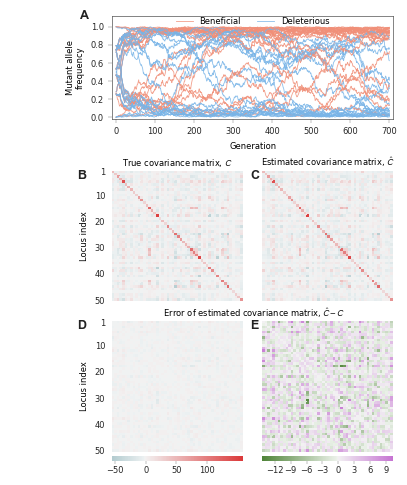

In [4]:
reload()
FIG.plot_figure_traj_cov_example(traj, selection, true_cov, est_cov, 
    save_file=FIG_DIR + "/fig-traj-cov-example.svg")

<a id='fig2'></a>

### Figure 2. Normalization and choosing a proper time window are important to accurate estimation of linkage information.

In [5]:
reload()
(true_cov_all, est_cov_all, 
 est_cov_unnormalized_all) = DP.load_cov_one_for_each_selection(window=20)
(error_normalized_window, 
 error_unnormalized_window) = DP.load_cov_error_with_various_windows()

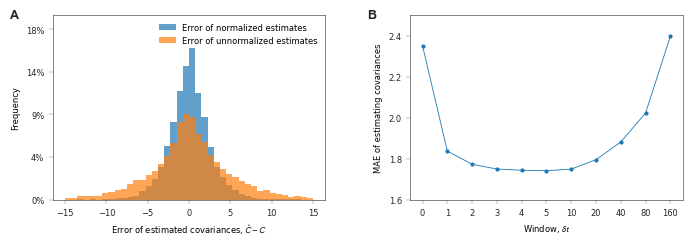

In [6]:
reload()
FIG.plot_figure_performance_estimation_normalization_window(
    true_cov_all, est_cov_all, est_cov_unnormalized_all, 
    error_normalized_window,
    save_file=FIG_DIR + "/fig-cov-hist-norm-window-double.svg")


<a id='fig3'></a>

### Figure 3.  Estimated covariance can improve inference of selection coefficients with ample data.

In [40]:
reload()
performances = DP.load_performance(window=20)
performances_vid = DP.load_performance(window=20, varying_initial=True)

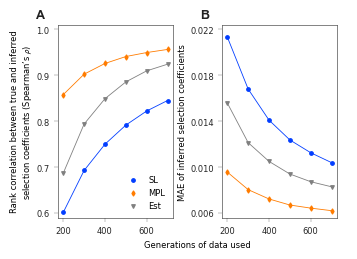

In [8]:
reload()
FIG.plot_figure_performance_with_ample_data(
    performances, truncate_list=TRUNCATE, arrange_vertically=False,
    save_file=FIG_DIR + "/fig-performance-ample-data.svg")

In [10]:
# reload()
# FIG.plot_figure_performance_with_ample_data(
#     performances_vid, truncate_list=TRUNCATE, arrange_vertically=False,
#     save_file=None)

<a id='fig4'></a>

### Figure 4. Performance is robust to sampling depth but sensitive to sampling time interval.

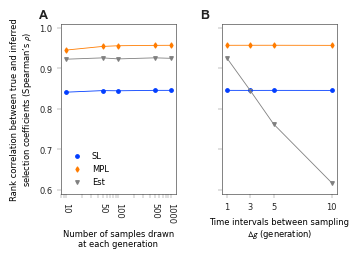

In [11]:
reload()
FIG.plot_figure_performance_with_limited_data(
    performances, truncate_index=5, 
    truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
    save_file=FIG_DIR + "/fig-performance-limited-data.svg")

In [12]:
# reload()
# FIG.plot_figure_performance_with_limited_data(
#     performances_vid, truncate_index=5, 
#     truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
#     save_file=None)

<a id='fig5'></a>

### Figure 5. A proper strength of linear shrinkage can improve performance un-der limited sampling effects.

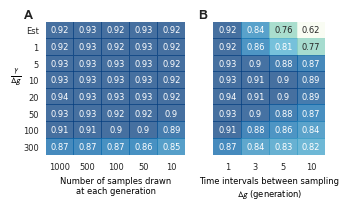

In [13]:
reload()
FIG.plot_figure_performance_with_linear_shrinkage(
    performances, truncate_index=5, 
    save_file=FIG_DIR + "/fig-performance-linear-shrinkage.svg")

In [14]:
# reload()
# FIG.plot_figure_performance_with_linear_shrinkage(
#     performances_vid, truncate_index=5, 
#     truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, linear_list=LINEAR, 
#     save_file=None)

<a id='fig6'></a>

### Figure 6. Performance can be greatly improved by combining data from multiple replicates.

In [41]:
reload()
performances_combine = DP.load_performance_combine(window=20)
performances_combine_vid = DP.load_performance_combine(window=20, 
                           varying_initial=True)

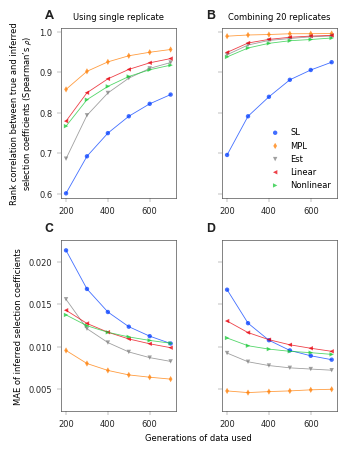

In [16]:
reload()
FIG.plot_figure_performance_combining_multiple_replicates_2x2(
    performances, performances_combine, 
    save_file=FIG_DIR + "/fig-performance-combining-replicates.svg")

<a id='fig7'></a>

### Figure 7. Performance  improves  as  the  number  of  combined  replicates  increases.

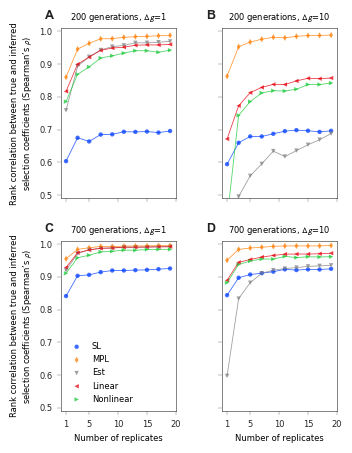

In [17]:
reload()
FIG.plot_figure_performance_combining_different_numbers_of_replicates(
    performances_combine,
    save_file=FIG_DIR + "/fig-performance-number-of-replicates.svg")

<a id='fig8'></a>

### Figure 8. Performance on real data

In [18]:
reload()
DP.save_traj_for_haplosep_cry1ac()

In [20]:
reload()
data = DP.parse_data_cry1ac()
results_nonlinear = DP.infer_genotype_fitness(data, DP.Cry1Ac_PARAMS)
results_est = DP.infer_genotype_fitness(data, DP.Cry1Ac_PARAMS, nonlinear_reg=False)

In [21]:
selection_list = [results_est['selection_by_true_cov'], 
                  results_est['selection_by_est_cov'],
                  results_nonlinear['selection_by_est_cov'],
                  results_est['selection_by_SL'],
                 ]
fitness_list = [results_est['fitness_by_true_cov'], 
                results_est['fitness_by_est_cov'],
                results_nonlinear['fitness_by_est_cov'],
                results_est['fitness_by_SL'],
                ]

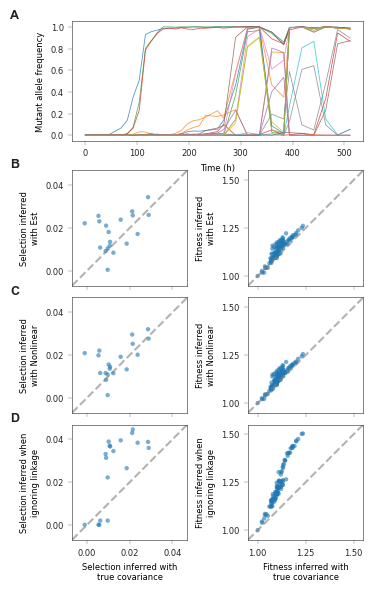

In [22]:
reload()
FIG.plot_figure_performance_real_data(data, selection_list, fitness_list,
    save_file=FIG_DIR + "/fig-performance-Cry1Ac.svg")

<a id='figs1'></a>

### Supplementary Fig 1. Uniform, trimodal and Gaussian distributions are used to generate 10 sets of selection coefficients used in simulations.

In [23]:
reload()
selections_true = SS.load_selections()

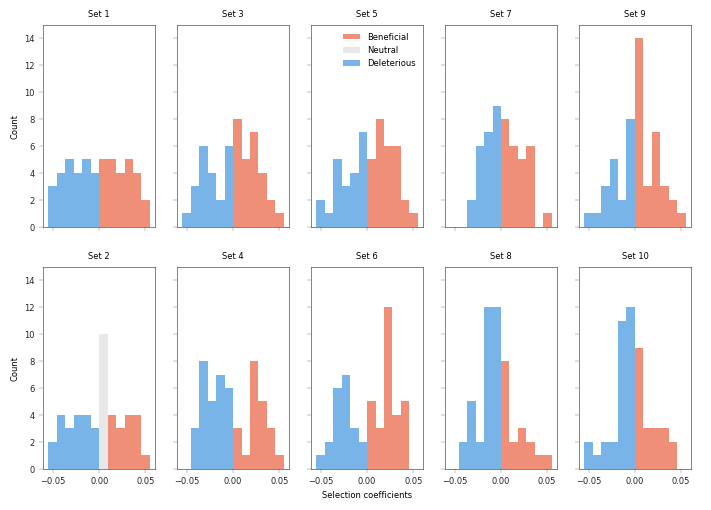

In [24]:
reload()
FIG.plot_supplementary_figure_selections(selections_true, alpha=1, 
    save_file=FIG_DIR + "/figs-selection-coefficients.svg")

<a id='figs2'></a>

### Supplementary Fig 2. Regularization restrains large terms in the inverse of estimated covariance matrix.

In [25]:
reload()
s, n = 4, 0
dic_cov = DP.load_complete_cov_for_a_simulation(s=s, n=n)
selection = SS.load_selection(s)

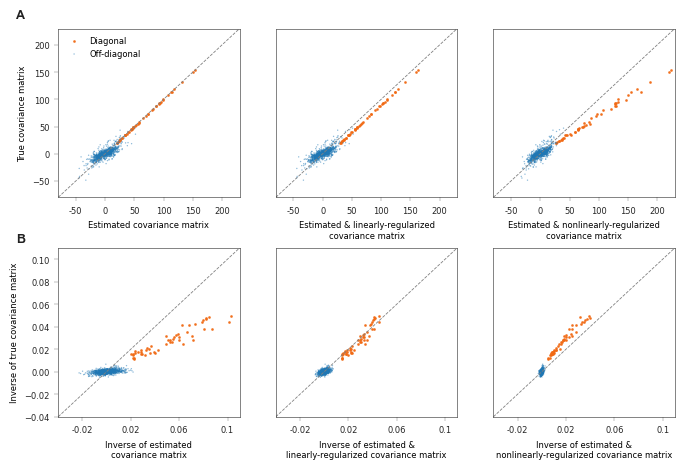

In [26]:
reload()
FIG.plot_supplementary_figure_biplot_cov(
    dic_cov, p=2, q=3,
    save_file=FIG_DIR + "/figs-covariance-regularization-biplot.svg")

<a id='figs3'></a>

### Supplementary Fig 3.  Normalization improves performances of both estimating covariance and inferring selection.

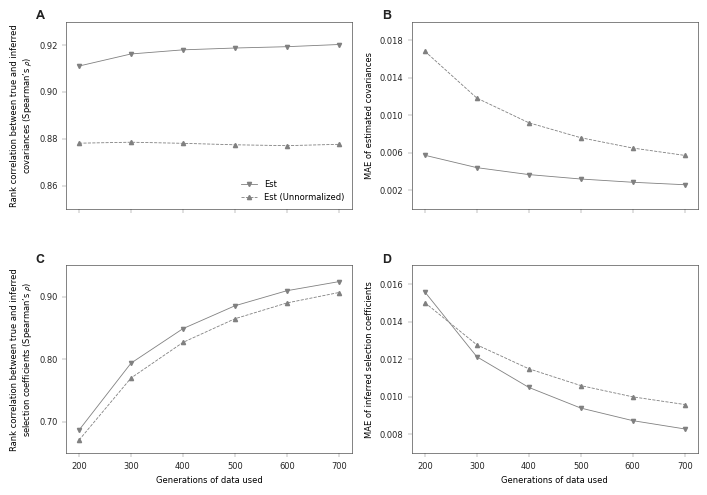

In [27]:
reload()
FIG.plot_supplementary_figure_performance_with_without_normalization(
    performances, 
    save_file=FIG_DIR + "/figs-performance-normalization.svg")

In [28]:
# reload()
# FIG.plot_supplementary_figure_performance_with_without_normalization(
#     performances_vid, 
#     save_file=None)

<a id='figs4'></a>

### Supplementary Fig 4.   Performance improves with larger time windows.

In [29]:
reload()
performances_window = DP.load_performance_window()

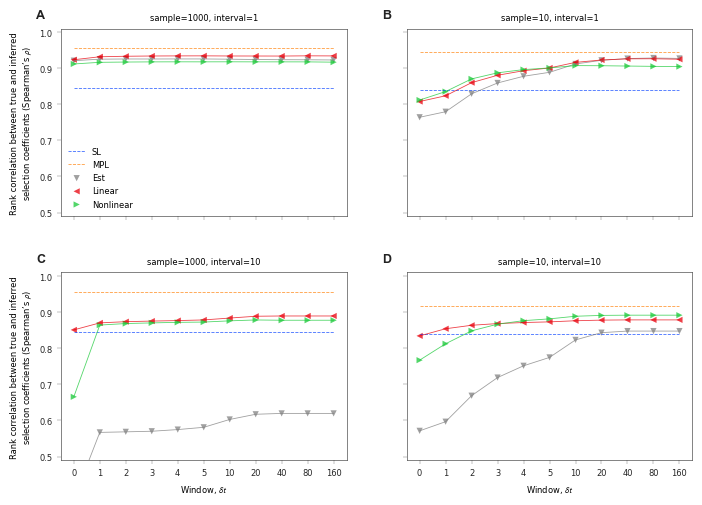

In [30]:
reload()
FIG.plot_supplementary_figure_performance_with_different_time_window(
    performances_window, max_q=3, max_p=4, 
    uncalibrated=False, alpha=0.75,
    save_file=FIG_DIR + "/figs-performance-time-window.svg")

### Supplementary Fig 4. Selection coefficients can be accurately inferred with ample data. 

In [31]:
reload()
selections = DP.load_selection()

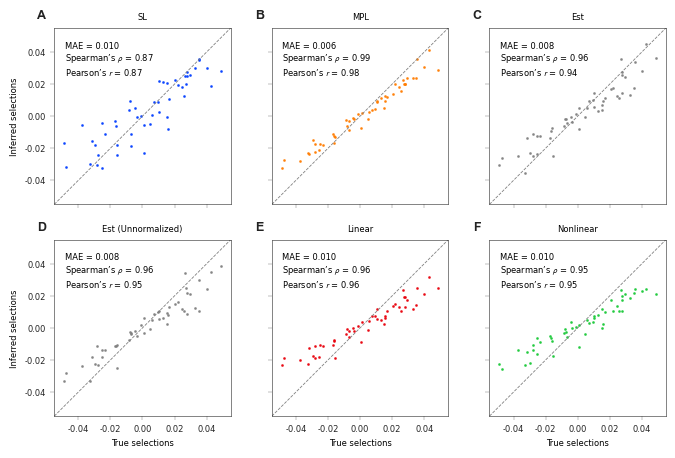

In [32]:
reload()
FIG.plot_supplementary_figure_performance_example(selections,
    save_file=FIG_DIR + "/figs-performance-example.svg")

<a id='figs5'></a>

### Supplementary Fig 5.   Nonlinear shrinkage performs best with a small regularization strength $\eta$.

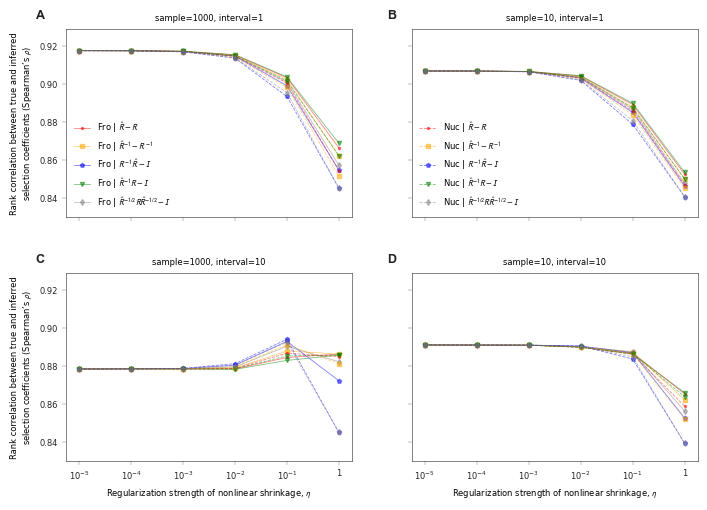

In [33]:
reload()
FIG.plot_supplementary_figure_performance_with_different_loss_gamma(
    performances, truncate_index=5,
    save_file=FIG_DIR + "/figs-performance-gamma-loss.svg")

<a id='figs6'></a>

### Supplementary Fig 6.  Spearman's $\rho$ of all tested methods.

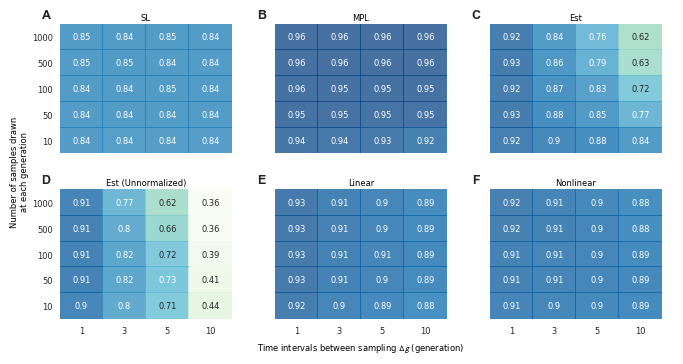

In [34]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances, 
    metrics='spearmanr', truncate_index=5, vmin=0.36, vmax=0.96,
    save_file=FIG_DIR + "/figs-Spearmanr-all-methods.svg")

<a id='figs7'></a>

### Supplementary Fig 7.   MAE of inferred selections of all tested methods.

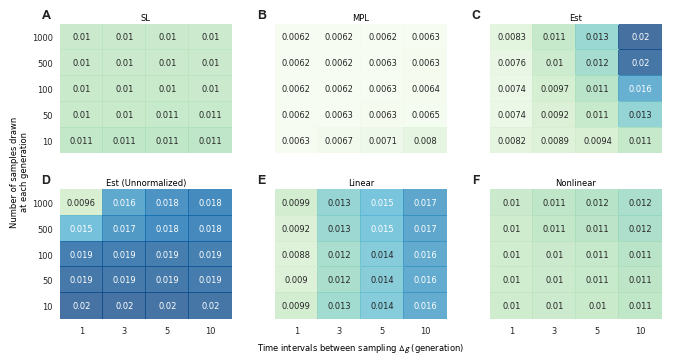

In [35]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances, 
    truncate_index=5, vmin=0.006, vmax=0.02,
    save_file=FIG_DIR + "/figs-MAE-all-methods.svg")

<a id='figs8'></a>

### Supplementary Fig 8. Spearman's $\rho$ of all tested methods for simulated data with recombination. 

In [36]:
performances_recomb = DP.load_performance(recombination=True, r=1e-5)

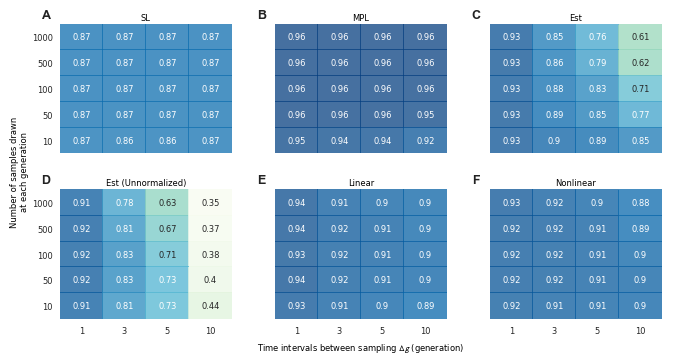

In [37]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances_recomb, 
    metrics='spearmanr', truncate_index=5, vmin=0.36, vmax=0.96,
    save_file=FIG_DIR + "/figs-Spearmanr-all-methods-recomb.svg")

<a id='figs9'></a>

### Supplementary Fig 9. MAE of inferred selections of all tested methods for simulated data with recombination. 

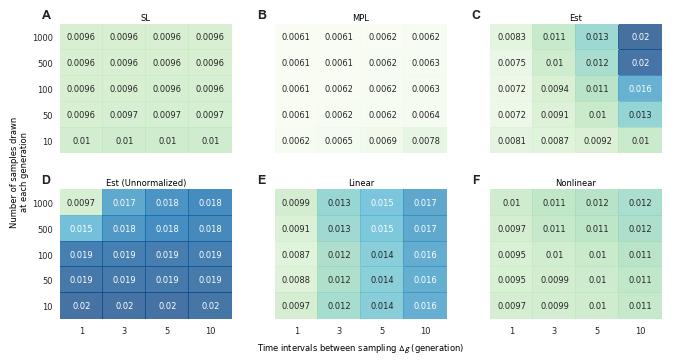

In [38]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances_recomb, 
    truncate_index=5, vmin=0.006, vmax=0.02,
    save_file=FIG_DIR + "/figs-MAE-all-methods-recomb.svg")

<a id='figs10'></a>

### Supplementary Fig 10.  Spearman's $\rho$ of all tested methods on simulated data with different initial populations.

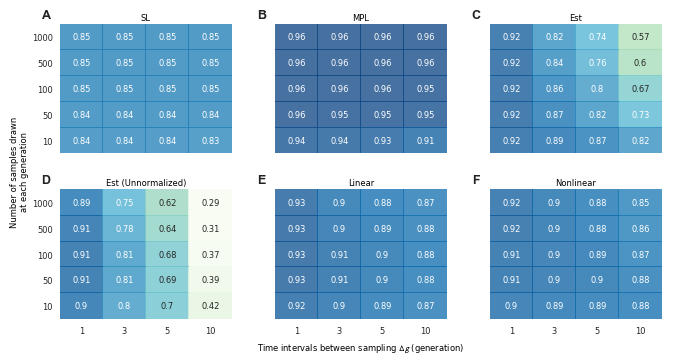

In [42]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances_vid, 
    metrics='spearmanr', truncate_index=5, vmin=0.36, vmax=0.96,
    save_file=FIG_DIR + "/figs-Spearmanr-all-methods-vid.svg")

<a id='figs11'></a>

### Supplementary Fig 11.   MAE of inferred selections of all tested methods on simulated data with different initial populations.

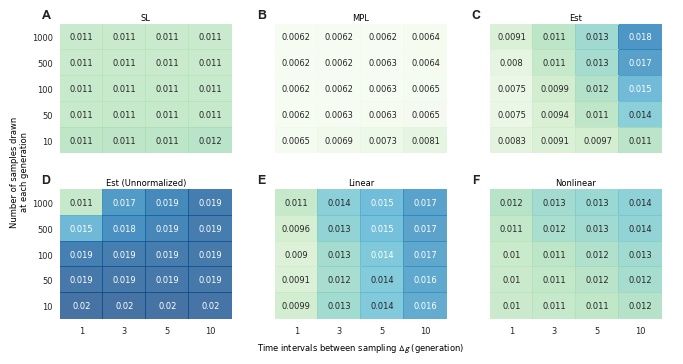

In [43]:
reload()
FIG.plot_supplementary_figure_performance_all_methods(performances_vid, 
    truncate_index=5, vmin=0.006, vmax=0.02,
    save_file=FIG_DIR + "/figs-MAE-all-methods-vid.svg")

<a id='figs12'></a>

### Supplementary Fig 12. Performance combining multiple replicates with different initial populations.

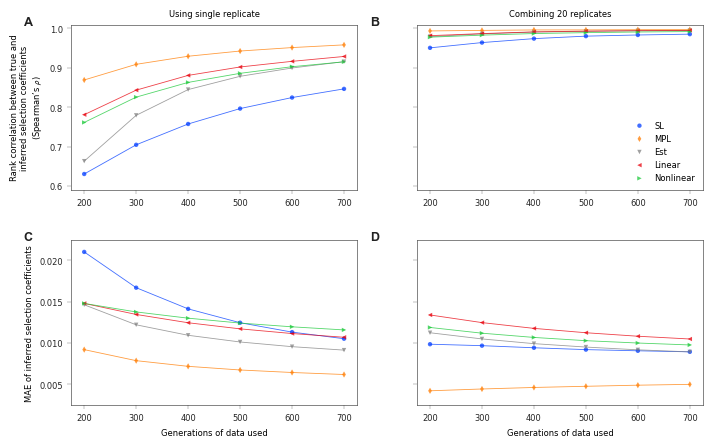

In [44]:
reload()
FIG.plot_figure_performance_combining_multiple_replicates_2x2(
    performances_vid, performances_combine_vid, double_column=True,
    save_file=FIG_DIR + "/fig-performance-combining-replicates-vid.svg")

<a id='figs13'></a>

### Supplementary Fig 13. Performance v.s. number of combined replicates with different initial populations.

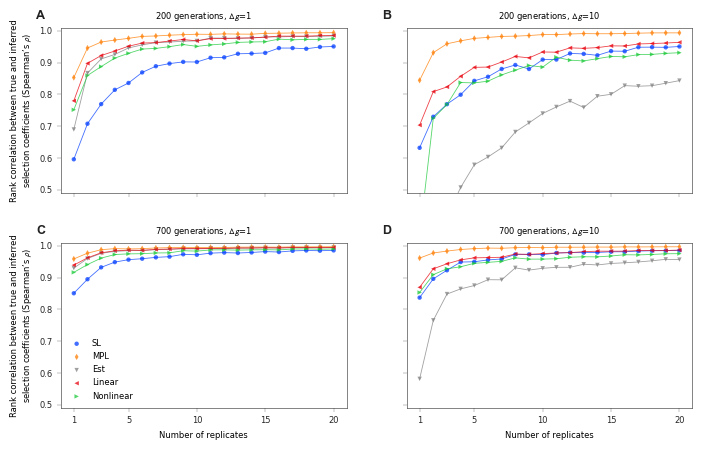

In [45]:
reload()
FIG.plot_figure_performance_combining_different_numbers_of_replicates(
    performances_combine_vid, double_column=True,
    save_file=FIG_DIR + "/fig-performance-number-of-replicates-vid.svg")

<a id='figs14'></a>

### Supplementary Fig 14. Performance of Evoracle and haploSep on the simulated data.  

In [46]:
reload()
performances_evoracle = DP.load_simulation_results_for_evoracle()
performances_haplosep = DP.load_simulation_results_for_haplosep()
covariances = DP.load_covariances()

In [47]:
%%time
reload()
(MAE_cov, spearmanr_cov, MAE_selection, 
 spearmanr_selection) = DP.parse_performances_on_covariances_selections_all_methods(
    selections, covariances, performances_evoracle, performances_haplosep)

/Users/yunxiao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/yunxiao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 12.9 s, sys: 103 ms, total: 13 s
Wall time: 3.52 s


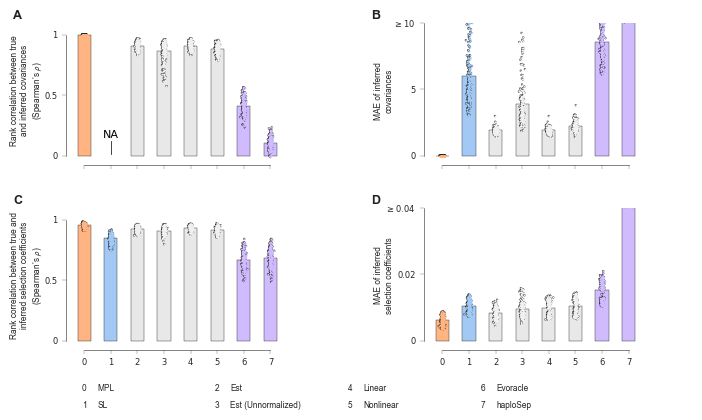

In [48]:
reload()
FIG.plot_supplementary_figure_performance_alternative_methods(
    MAE_cov, spearmanr_cov, MAE_selection, spearmanr_selection,
    save_file=FIG_DIR + "/figs-perf-evoracle-haplosep.svg")